## Hackathon

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [2]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [3]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

In [4]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)

In [ ]:
# Convert to dataframe

subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [5]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })
    return df

In [10]:
def generate_eval_data_non_rand(lon, lat, start_date=['2023-05-01'], end_date=['2023-05-21']):
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date,
        "end_date": end_date
    })
    return df

In [11]:
def sine_model(x, A, b, c, d):
    sin = A * np.sin(2*np.pi/c * (x+b)) + d
    return sin

In [12]:
def ARIMA_sine_fitted(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    
    t = np.arange(len(history))

    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    try:
        params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
        A, b, c, d= params

        d -= np.mean(history)
    except:
        A, b, c, d = [0.0, 0.0, 1.0, 0.0]

    y = sine_model(t, A, b, c, d)

    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)

    x = np.arange(start=len(history), stop=len(history) + n_points)

    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    delta = history[-1] - forecast_fitted[0]

    forecast_fitted += delta

    return forecast_fitted

In [6]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred))

In [7]:
def evaluator(function, n_samples = 100):
    errors = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors)

In [ ]:
evaluator(ARIMA_sine_fitted, 250)

In [ ]:
# Generate error map

error_df_ARIMA_UPDATED = pd.DataFrame(columns=['lon', 'lat', 'error'])

high_error = []

for lat in range(3400, 7150, 25):
    for lon in range(-2500, 3750, 25):
        df = generate_eval_data_non_rand(lon / 100, lat/ 100)
        error= forecast_1w(df.iloc[0], ARIMA_sine_fitted, operation = 'loop')
        error_df_ARIMA_UPDATED.loc[len(error_df_ARIMA_UPDATED)] = [lon / 100, lat / 100, error]

        if np.mean(error) > 7.0:
            lon_lat = [lon / 100, lat / 100]
            high_error.append(lon_lat)



In [21]:
error_df_ARIMA_UPDATED = pd.read_csv('ARIMA_error.csv', index_col='Unnamed: 0')

In [22]:
print(error_df_ARIMA_UPDATED['error'].mean())

2.1587987752946582


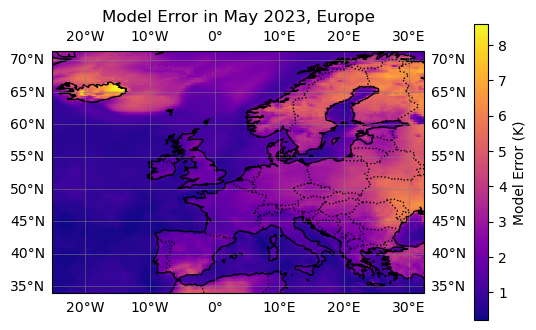

In [27]:
# Vind unieke waarden
lons = np.sort(error_df_ARIMA_UPDATED['lon'].unique())
lats = np.sort(error_df_ARIMA_UPDATED['lat'].unique())

# Reshape error naar 2D-array
error_grid = error_df_ARIMA_UPDATED['error'].values.reshape(len(lats), len(lons))


# Maak meshgrid
LON, LAT = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Inverted cmap + manual scale
#vmin, vmax = 0.21303982325127824, 9.697968226707493  # 👈 adjust manually as needed
pcm = ax.pcolormesh(
    LON,
    LAT,
    error_grid,
    cmap='plasma',
    shading='auto'
)

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.7)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Model Error (K)')

ax.set_title('Model Error in May 2023, Europe')
plt.show()


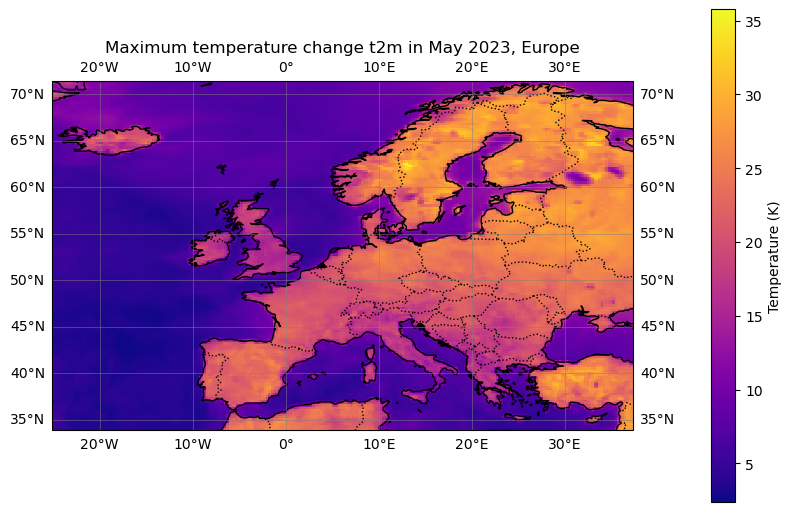

In [ ]:
# Task 1
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

t2m_values = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(34, 71.25),
    lon_range=(-25, 37.25)
)

monthly_mean = t2m_values['t2m'].max(dim='valid_time').values - t2m_values['t2m'].min(dim='valid_time').values

coords = np.stack([LAT, LON], axis=-1)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='plasma',
    shading='auto'
)


ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.7)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Maximum temperature change t2m in May 2023, Europe')
plt.show()
